In [1]:
import importlib
import torch
import IPython.display
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import torch.utils as utils
from torchvision import datasets, transforms
from sklearn.utils import resample
import librosa
import librosa.display
import os
import scipy.signal
import re
import sys
import common_func as cmm
import threading
import time
import queue
import pyaudio
import sys
import random 
importlib.reload(cmm)

<module 'common_func' from 'c:\\Users\\ryuhe\\Documents\\python\\vae\\common_func.py'>

In [2]:
#read data from jvs
sr = 24000
frame_len=4068
read_data = []
read_label = []
no_label=[6,28,30,37,58,74,89]
count=0
for i in range(1,100):
  print(count)
  if i in no_label:
    continue
  tmp_data,tmp_label = cmm.read_jvs(i,sr=sr,time_span=frame_len,threshold=0)

  read_data.append(tmp_data)
  read_label.append(tmp_label)
  count=count+1
  if count >= 100:
    break
read_data = np.concatenate(read_data)
read_label = np.concatenate(read_label)
print(read_data.shape)

0
1
2
3
4
5
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
26
27
27
28
29
30
31
32
33
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
82
83
84
85
86
87
88
89
90
91
(11116, 4068)


In [3]:
boin = ['a','i','u','e','o','a:','i:','u:','e:','o:']
read_data = np.array(read_data,dtype="float64")
for i,l in enumerate(read_label):
  read_label[i] = boin.index(l)%5
  print(l)
read_label = np.array(read_label,dtype="int64")


a
o
o
a
a
e
a
i
e
o
o
o
o
u
e
o
e
a
e
a
e
e
e
e
o
a
o
o
e
a
a
o
o
o
o
e
o
a
a
o
e
a
o
a
u
a
o
e
a
a
o
i
a
a
e
o
o
a
o
e
o
i
o
i
o
o
o
e
i
e
o
a
e
a
a
a
o
e
e
a
i
a
a
o
a
o
e
e
i
e
o
e
e
o
e
u
a
u
o
a
i
o
a
i
e
o
u
o
a
o
a
o
i
u
o
e
a
e
a
u
o
e
o
o
e
i
o
o
o
o
e
o
o
o
o
e
o
o
o
o
o
a
o
o
i
a
i
a
e
o
i
a
o
o
i
a
e
e
a
o
o
o
u
a
e
i
o
o
o
o
e
e
u
o
o
e
e
a
i
o
o
o
e
o
a
e
o
u
o
o
o
e
a
i
u
o
i
e
e
o
o
a
o
e
e
e
o
o
e
a
o
o
o
i
i
e
e
o
i
e
i
e
a
a
o
i
a
a
u
a
o
o
e
o
o
o
o
o
i
e
a
e
a
a
e
a
a
a
o
o
e
i
e
o
a
e
o
o
e
u
i
a
o
e
e
a
e
i
o
a
a
o
i
e
i
o
i
e
o
e
o
o
o
o
i
e
i
e
o
i
a
u
o
e
e
o
u
o
o
u
e
o
i
a
i
o
e
o
o
e
e
a
i
o
u
e
o
e
o
a
i
o
u
o
a
a
e
a
i
o
i
e
a
o
u
o
o
a
u
a
e
o
a
e
a
e
a
e
a
e
i
e
e
o
a
i
o
a
e
a
o
o
a
o
o
o
a
o
e
o
i
u
a
a
o
o
a
i
o
e
e
o
a
i
u
a
a
i
o
e
i
e
a
a
o
i
a
a
o
u
o
o
a
o
e
i
o
o
e
o
a
o
o
i
e
o
a
i
i
e
a
a
a
i
o
a
a
e
i
o
a
a
o
a
o
o
e
e
e
i
e
o
u
a
a
a
e
a
e
o
o
e
u
e
i
a
a
o
i
a
a
i
o
u
o
a
a
i
i
o
a
o
i
a
u
i
u
o
o
a
e
a
i
o
i
u
a
o
o
e
a
a
u
u
a
e
o
a
o
a


In [4]:
# 各クラスの数をカウント
class_counts = np.bincount(read_label)
for cnt in class_counts:
  print(cnt)
# 最少のクラス数を取得
min_class_count = np.min(class_counts)

# 各クラスごとにサンプリング数を均等化
balanced_data = []
balanced_label = []

for class_label in np.unique(read_label):
    class_indices = np.where(read_label == class_label)[0]
    balanced_indices = resample(class_indices, n_samples=min_class_count, random_state=42)

    balanced_data.extend(read_data[balanced_indices])
    balanced_label.extend(read_label[balanced_indices])

balanced_data = np.array(balanced_data)
balanced_label = np.array(balanced_label)

print(balanced_label.shape)
print(read_label[0])
sample_num = 50000
if balanced_data.shape[0]>sample_num:
  random_index = random.sample(range(balanced_data.shape[0]),sample_num)
  random_index = np.array(random_index)
  balanced_data = balanced_data[random_index]
  balanced_label = balanced_label[random_index]

2874
1374
786
2461
3621
(3930,)
0


In [5]:
balanced_label.shape

(3930,)

In [7]:
pitch_shifted_label = []
pitch_shifted_data = []
pitch_ran = np.arange(-3,3,0.2)

for n,audio in enumerate(balanced_data):
  for i in pitch_ran:
    audio=audio.astype(np.float32)
    shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=i)  # ピッチを上げる
    pitch_shifted_data.append(shifted)
    pitch_shifted_label.append(balanced_label[n])

In [8]:
augmented_data = pitch_shifted_data
augmented_label = pitch_shifted_label

In [9]:
#input_dim = 80  # メルスペクトログラムの次元数

#n_fft = 800
#hop_length = 160



# augmented_dataの音声データを順番に再生
augmented_data = np.array(augmented_data)
augmented_label = np.array(augmented_label)
print(augmented_data.shape)
print(augmented_label.shape)
number = 0
print(augmented_label[number])
IPython.display.Audio(augmented_data[number], rate=sr)


(117900, 4068)
(117900,)
0


In [10]:
from torch.utils.data.dataset import random_split
# メルスペクトログラムの抽出
mel_data = []
input_dim = 64
n_fft = 512
hop_length = 256
n_mels = input_dim


print(augmented_data.shape)
for audio in augmented_data:
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,center=False)
    log_mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
    #log_mel_spec = librosa.amplitude_to_db(mel_spec, ref=2.0e-06)
    mel_data.append(log_mel_spec)
def normal(x):

  x_scaled = (x-x.min())/(x.max()-x.min())

  return x_scaled
np_meldata = np.array(mel_data)
print(np_meldata.shape)

(117900, 4068)
(117900, 64, 14)


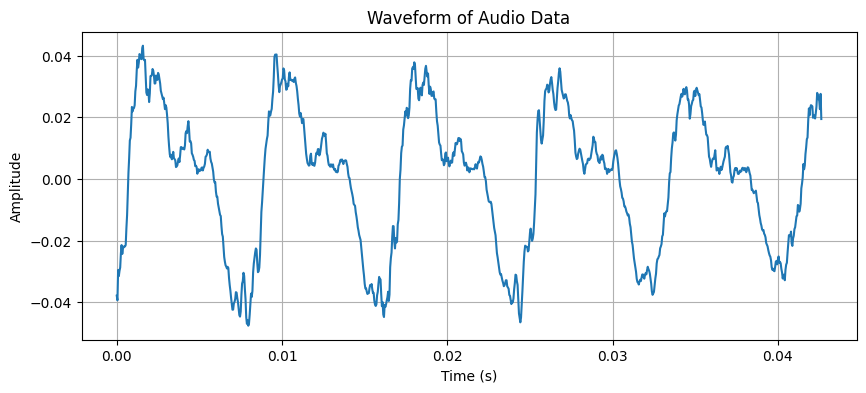

In [204]:
%matplotlib inline
# サンプリングレートとサンプル数を指定
sample_rate = sr  # サンプリングレート (Hz)
num_samples = frame_len  # サンプル数

# サンプルデータを生成（仮のデータとしてランダムな値を使用）
# ここで、実際の音声データを使用する場合は、適切な方法で読み込んでください。
audio_data = augmented_data[0]

# サンプル数を時間に変換
time = np.arange(0, num_samples) / sample_rate

# 波形グラフをプロット
plt.figure(figsize=(10, 4))
plt.plot(time, audio_data)
plt.title('Waveform of Audio Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

117900
94320


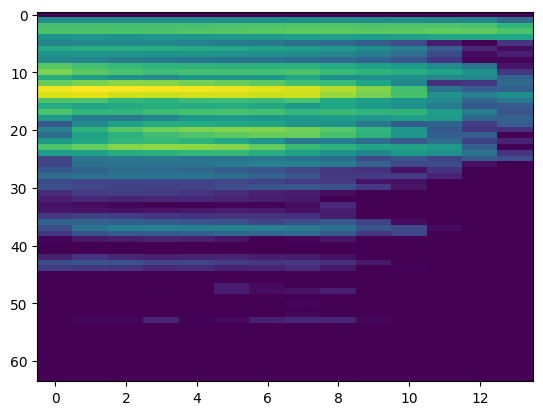

In [11]:

# 特徴量:メルスペクトログラム
x_size = np_meldata.shape[1]
y_size = np_meldata.shape[2]
fig, axs = plt.subplots(1,1)
axs.imshow(np_meldata[1],aspect="auto")
#標準化
dataset_mean=0
dataset_std=0

normaled_np_meldata = normal(np_meldata)
batch_size = 20


# データセット作成
normaled_np_meldata = normaled_np_meldata[:,np.newaxis,:,:]

X = torch.tensor(normaled_np_meldata,dtype=torch.float32)
Y = torch.tensor(augmented_label,dtype=torch.int64)
dataset = torch.utils.data.TensorDataset(X,Y)

train_size = int(0.8*len(dataset))
eval_size = len(dataset)-train_size
print(train_size+eval_size)
train_dataset,eval_dataset = torch.utils.data.random_split(dataset,[train_size,eval_size])
print(len(train_dataset))

dataloader_train =  torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=0
)
dataloader_valid =  torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=300,
    shuffle=True,
    num_workers=0
)


23580
18864


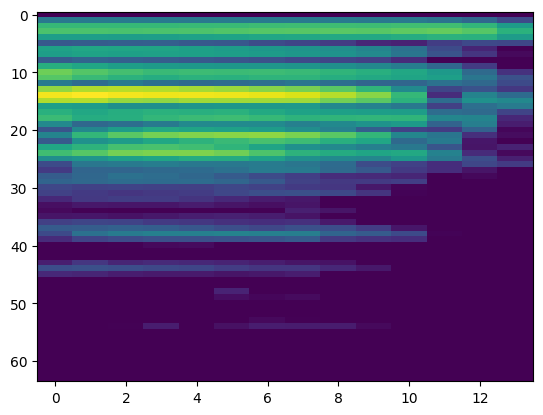

In [26]:


# 特徴量:メルスペクトログラム
x_size = np_meldata.shape[1]
y_size = np_meldata.shape[2]
fig, axs = plt.subplots(1,1)
axs.imshow(np_meldata[1],aspect="auto")
#標準化
dataset_mean=0
dataset_std=0

dataset_mean = np_meldata.mean()
l2 = np_meldata - dataset_mean

dataset_std = l2.std()
normaled_np_meldata = l2/dataset_std

normaled_np_meldata = normal(normaled_np_meldata)
batch_size = 20


# データセット作成
normaled_np_meldata = normaled_np_meldata[:,np.newaxis,:,:]

X = torch.tensor(np_meldata,dtype=torch.float32)
Y = torch.tensor(augmented_label,dtype=torch.int64)
dataset = torch.utils.data.TensorDataset(X,Y)

train_size = int(0.8*len(dataset))
eval_size = len(dataset)-train_size
print(train_size+eval_size)
train_dataset,eval_dataset = torch.utils.data.random_split(dataset,[train_size,eval_size])
print(len(train_dataset))

dataloader_train =  torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=0
)
dataloader_valid =  torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=300,
    shuffle=True,
    num_workers=0
)


In [12]:
num_epochs = 50
device = torch.device("cuda")

In [13]:
import torch
print(torch.cuda.is_available())

True


EPOCH: 0 loss: 48742.7890625
EPOCH: 1 loss: 33718.28515625
EPOCH: 2 loss: 31075.845703125
EPOCH: 3 loss: 29671.310546875
EPOCH: 4 loss: 29051.109375
EPOCH: 5 loss: 28762.375
EPOCH: 6 loss: 28568.021484375
EPOCH: 7 loss: 28395.958984375
EPOCH: 8 loss: 28298.900390625
EPOCH: 9 loss: 28159.580078125
EPOCH: 10 loss: 28033.8671875
EPOCH: 11 loss: 27968.162109375
EPOCH: 12 loss: 27880.748046875
EPOCH: 13 loss: 27828.849609375
EPOCH: 14 loss: 27799.96875
EPOCH: 15 loss: 27745.705078125
EPOCH: 16 loss: 27721.4296875
EPOCH: 17 loss: 27688.978515625
EPOCH: 18 loss: 27686.36328125
EPOCH: 19 loss: 27648.46875


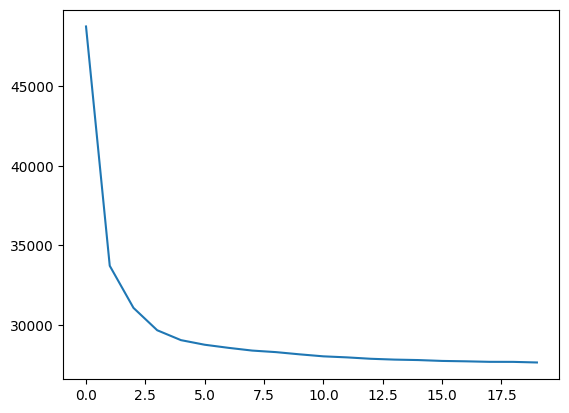

In [16]:
model = cmm.VAE(x_dim=x_size*y_size, z_dim=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()


loss_list = []
for i in range(num_epochs):
  losses = []
  for x, t in dataloader_train:
      x = x.to(device)
      loss, z, y = model(x, device)
      model.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.cpu().detach().numpy())
  loss_list.append(np.average(losses))
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))

plt.plot(loss_list)

plt.show()

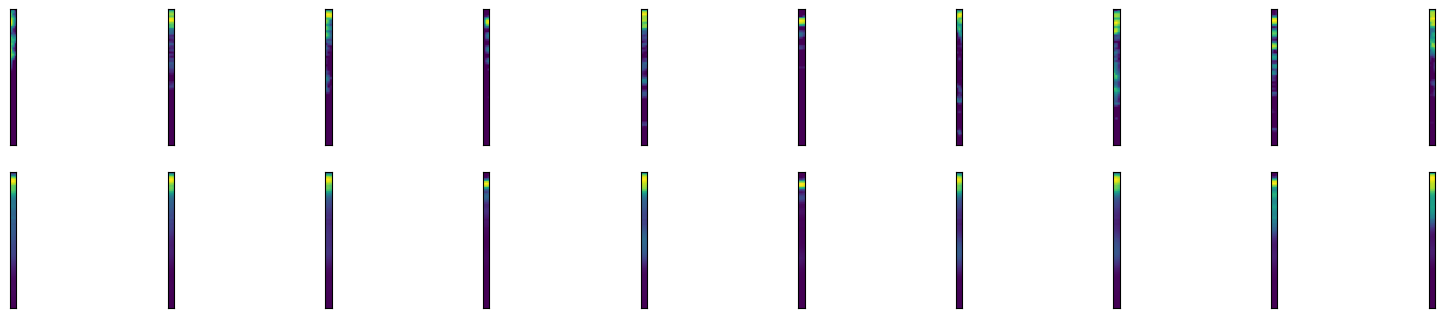

In [209]:
fig = plt.figure(figsize=(20, 6))

model.eval()
zs = []
for x, t in dataloader_valid:
    for i, im in enumerate(x.view(-1, x_size, y_size).detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
      ax.imshow(im)

    x = x.to(device)
    tmp, z, y = model(x,device)
    zs.append(z)
    y = y.view(-1, x_size, y_size)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
      ax.imshow(im)

    break

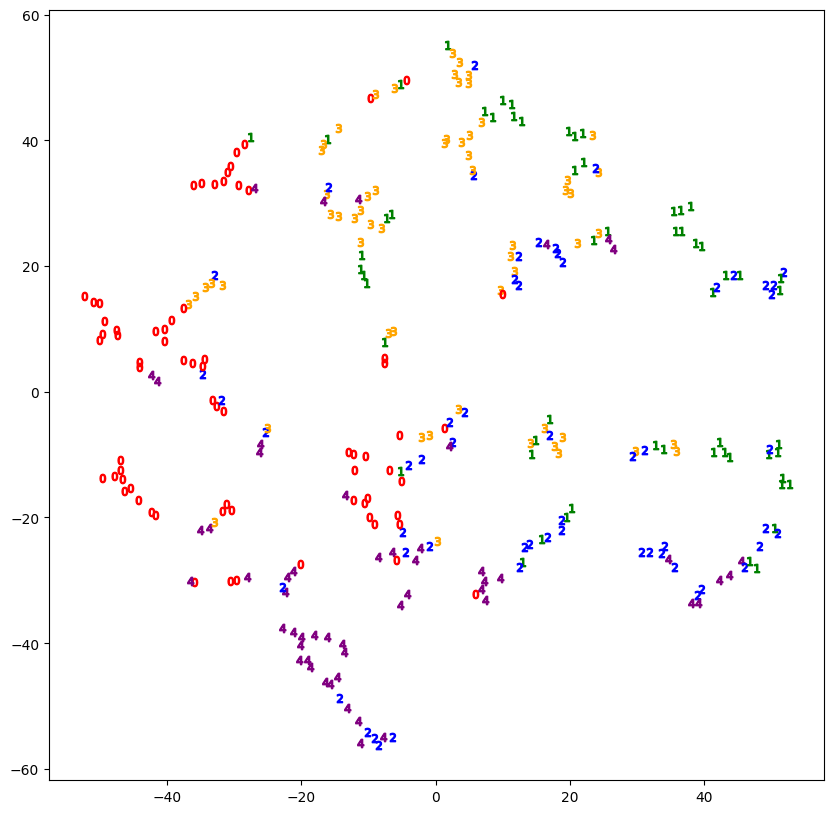

In [210]:
from sklearn.manifold import TSNE
from random import random

colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
def visualize_zs(zs, labels):
  plt.figure(figsize=(10,10))
  points = TSNE(n_components=2, random_state=0,perplexity=5).fit_transform(zs)
  for p, l in zip(points, labels):
    plt.scatter(p[0], p[1], marker="${}$".format(l), c=colors[l])
  plt.show()

model.eval()
zs = []
for x, t in dataloader_valid:
    x = x.to(device)
    t = t.to(device)
    # generate from x
    tmp, z, y = model(x,device)
    z = z.cpu()
    t = t.cpu()
    visualize_zs(z.detach().numpy(), t.cpu().detach().numpy())
    break

EPOCH: 0 loss: 32436.419921875
EPOCH: 1 loss: 28747.59765625
EPOCH: 2 loss: 28388.576171875
EPOCH: 3 loss: 28196.021484375
EPOCH: 4 loss: 28133.517578125
EPOCH: 5 loss: 28100.033203125
EPOCH: 6 loss: 28072.25390625
EPOCH: 7 loss: 28046.6484375
EPOCH: 8 loss: 28019.9296875
EPOCH: 9 loss: 27993.00390625
EPOCH: 10 loss: 27974.724609375
EPOCH: 11 loss: 27955.27734375
EPOCH: 12 loss: 27942.70703125
EPOCH: 13 loss: 27927.392578125
EPOCH: 14 loss: 27917.74609375
EPOCH: 15 loss: 27908.435546875
EPOCH: 16 loss: 27897.5546875
EPOCH: 17 loss: 27892.65625
EPOCH: 18 loss: 27888.384765625
EPOCH: 19 loss: 27879.96484375
EPOCH: 20 loss: 27873.216796875
EPOCH: 21 loss: 27863.865234375
EPOCH: 22 loss: 27856.177734375
EPOCH: 23 loss: 27843.25
EPOCH: 24 loss: 27846.419921875
EPOCH: 25 loss: 27839.1484375
EPOCH: 26 loss: 27837.435546875
EPOCH: 27 loss: 27828.89453125
EPOCH: 28 loss: 27833.474609375
EPOCH: 29 loss: 27828.486328125
EPOCH: 30 loss: 27824.888671875
EPOCH: 31 loss: 27824.876953125
EPOCH: 32 los

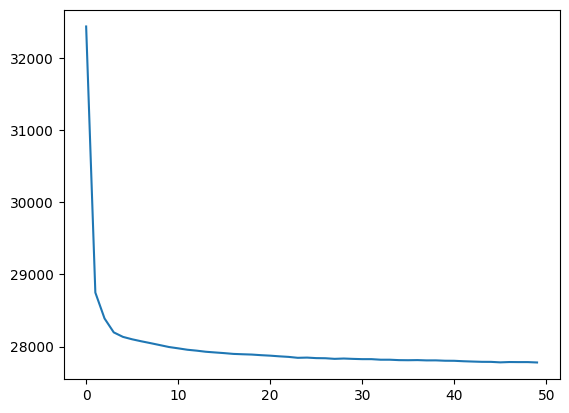

In [14]:

model = cmm.VAE(x_dim=x_size*y_size, z_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()


loss_list = []
for i in range(num_epochs):
  losses = []
  for x, t in dataloader_train:
      x = x.to(device)
      loss, z, y = model(x, device)
      model.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.cpu().detach().numpy())
  loss_list.append(np.average(losses))
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))

plt.plot(loss_list)

plt.show()


[3 2 3 2 3 0 2 1 2 3]


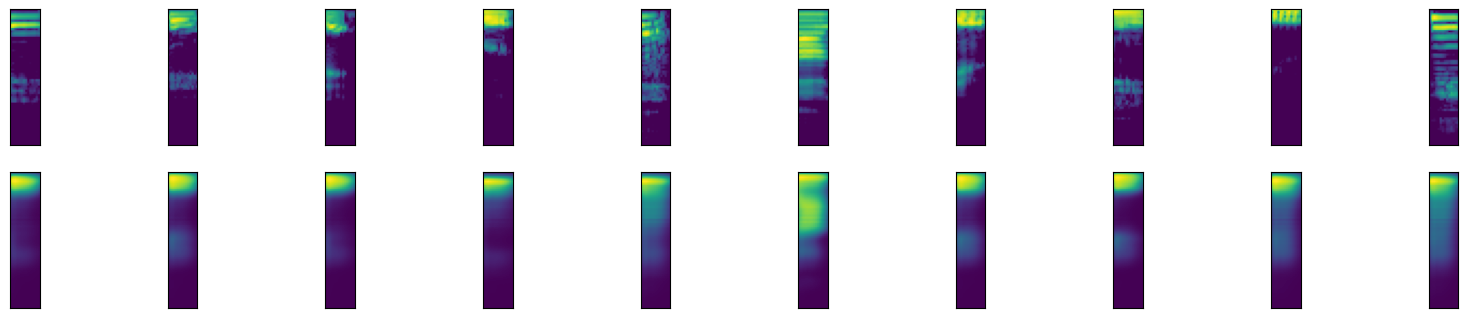

In [15]:
fig = plt.figure(figsize=(20, 6))

model.eval()
zs = []
for x, t in dataloader_valid:
    print(t.detach().numpy()[:10])
    for i, im in enumerate(x.view(-1, x_size, y_size).detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
      ax.imshow(im)

    x = x.to(device)
    tmp, z, y = model(x,device)
    zs.append(z)
    y = y.view(-1, x_size, y_size)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
      ax.imshow(im)
    break

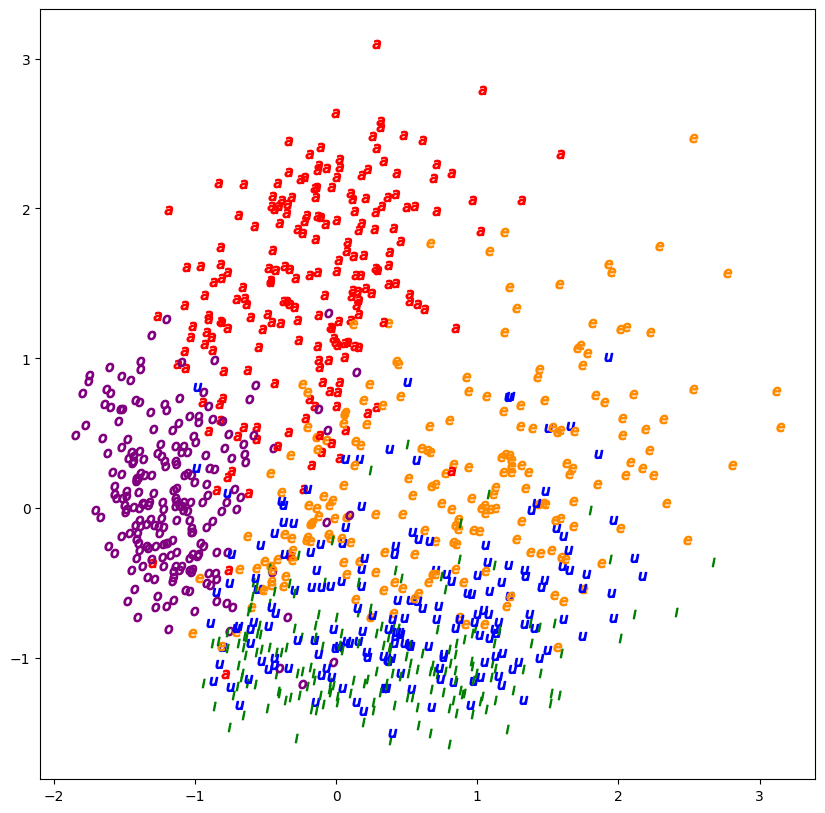

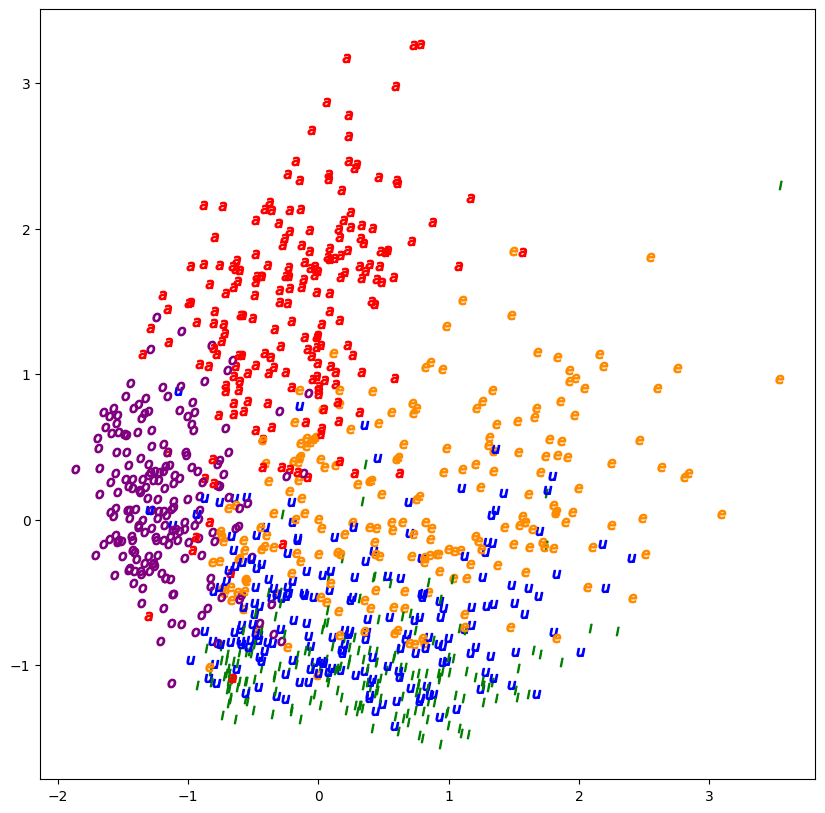

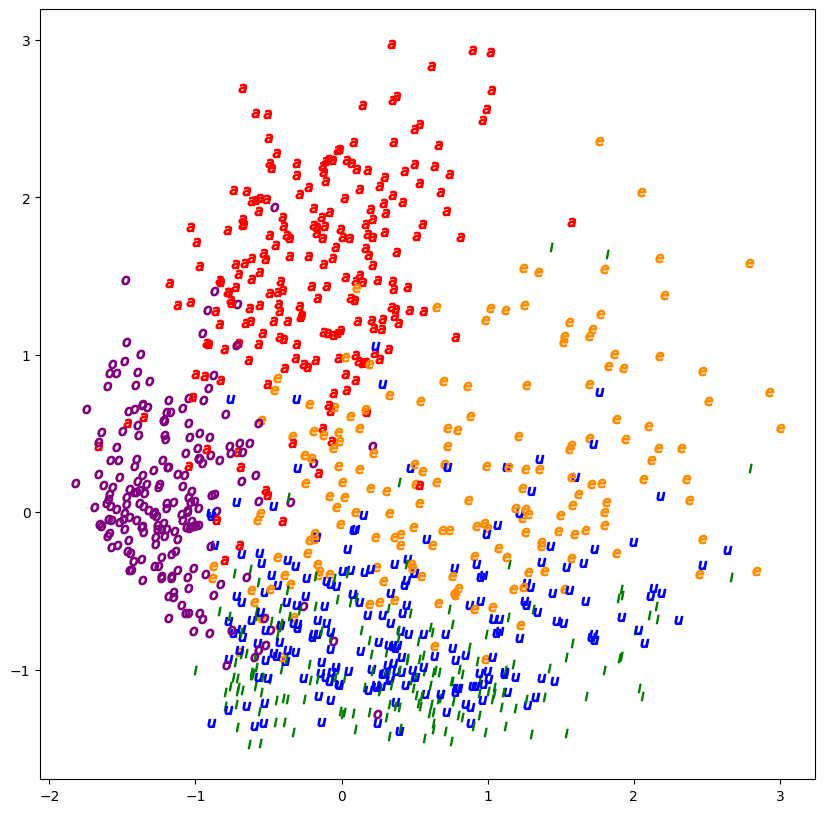

(3, 1000, 2)
(3, 1000)


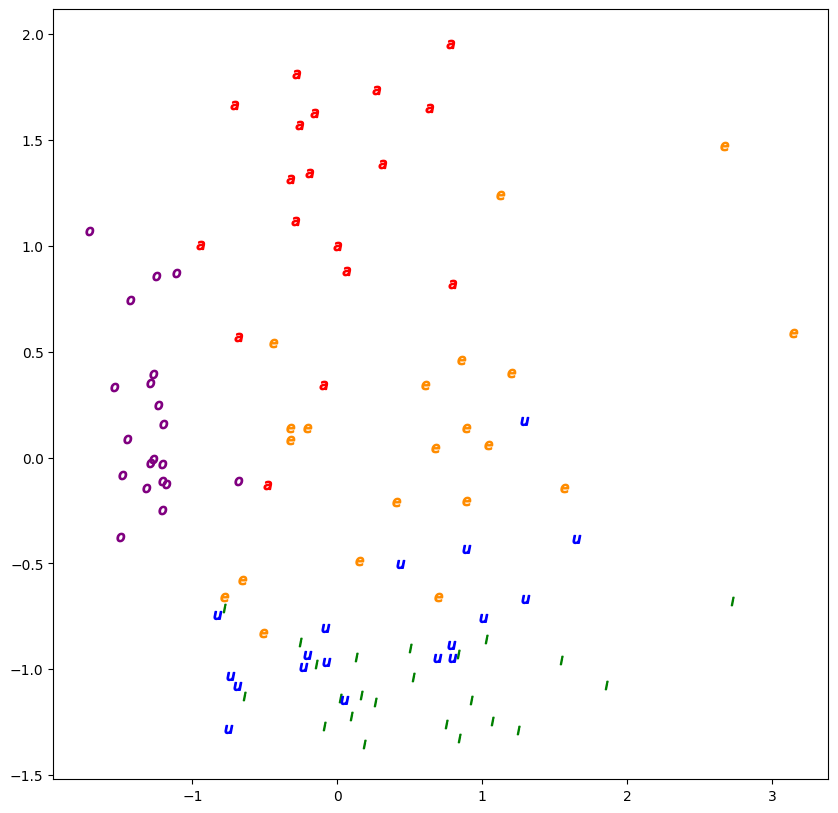

In [29]:
from sklearn.manifold import TSNE
from random import random


labeltoword = ["a","i","u","e","o"]
colors = ["red", "green", "blue", "darkorange", "purple"]
def visualize_zs(zs, labels):
  plt.figure(figsize=(10,10))
  points = zs
  for p, l in zip(points, labels):
    plt.scatter(p[0], p[1], marker="${}$".format(labeltoword[l]), c=colors[l])
  plt.show()

model.eval()
zs = []

dataloader_valid =  torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=1000,
    shuffle=True,
    num_workers=0
)
data = []
label = []
cnt = 0
for x, t in dataloader_valid:
    if cnt>2:
      break
    x = x.to(device)
    t = t.to(device)

    # generate from x
    tmp, z, y = model(x,device)
    z = z.cpu()
    t = t.cpu()
    data.append(z.detach().numpy())
    label.append(t.detach().numpy())
    visualize_zs(z.detach().numpy(), t.cpu().detach().numpy())
    cnt = cnt+1
data = np.array(data)
label = np.array(label)
print(data.shape)
print(label.shape)
for x, t in dataloader_train:

    x = x.to(device)
    t = t.to(device)
    # generate from x
    tmp, z, y = model(x,device)
    z = z.cpu()
    t = t.cpu()
    visualize_zs(z.detach().numpy(), t.cpu().detach().numpy())
    break

In [30]:
from sklearn.neighbors import KNeighborsClassifier
k = 3  # kの値を設定（近傍の数）
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(data[0], label[0])
predicted_labels = knn.predict(data[1])
count = 0
for i,pre in enumerate(predicted_labels):
  if pre == label[1][i]:
    count = count+1
acc = (count/len(label[1]))
print("acc:"+str(acc))
print(data[0].shape)
print(data[1].shape)

acc:0.662
(1000, 2)
(1000, 2)


In [33]:
from sklearn.svm import SVC
random_seed = 123
algorithm = SVC(kernel='rbf', probability=True, random_state=random_seed)
algorithm.fit(data[0],label[0])
def simulate(clf,xs,ys ,x_min=-3, x_max=3, y_min=-3, y_max=3):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    z = clf.predict(np.array([xx.ravel(), yy.ravel()]).T)
    ax.contourf(xx, yy, z.reshape(xx.shape), levels=5,alpha=0.6, colors=colors)
    
    """
    for p, l in zip(xs, ys):
        ax.scatter(p[0], p[1], marker="${}$".format(labeltoword[l]), c=colors[l])
    """
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    ax.axis("off")
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.savefig("z.png",bbox_inches="tight",pad_inches=0)
    plt.show()
    plt.clf()
    plt.close()

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    z = clf.predict(np.array([xx.ravel(), yy.ravel()]).T)
    ax.contourf(xx, yy, z.reshape(xx.shape),levels=5, alpha=0.6, colors=colors)
    print(z)
    
    for p, l in zip(xs, ys):
        ax.scatter(p[0], p[1], marker="${}$".format(labeltoword[l]), c=colors[l])
    
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    ax.axis("off")
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.show()
    

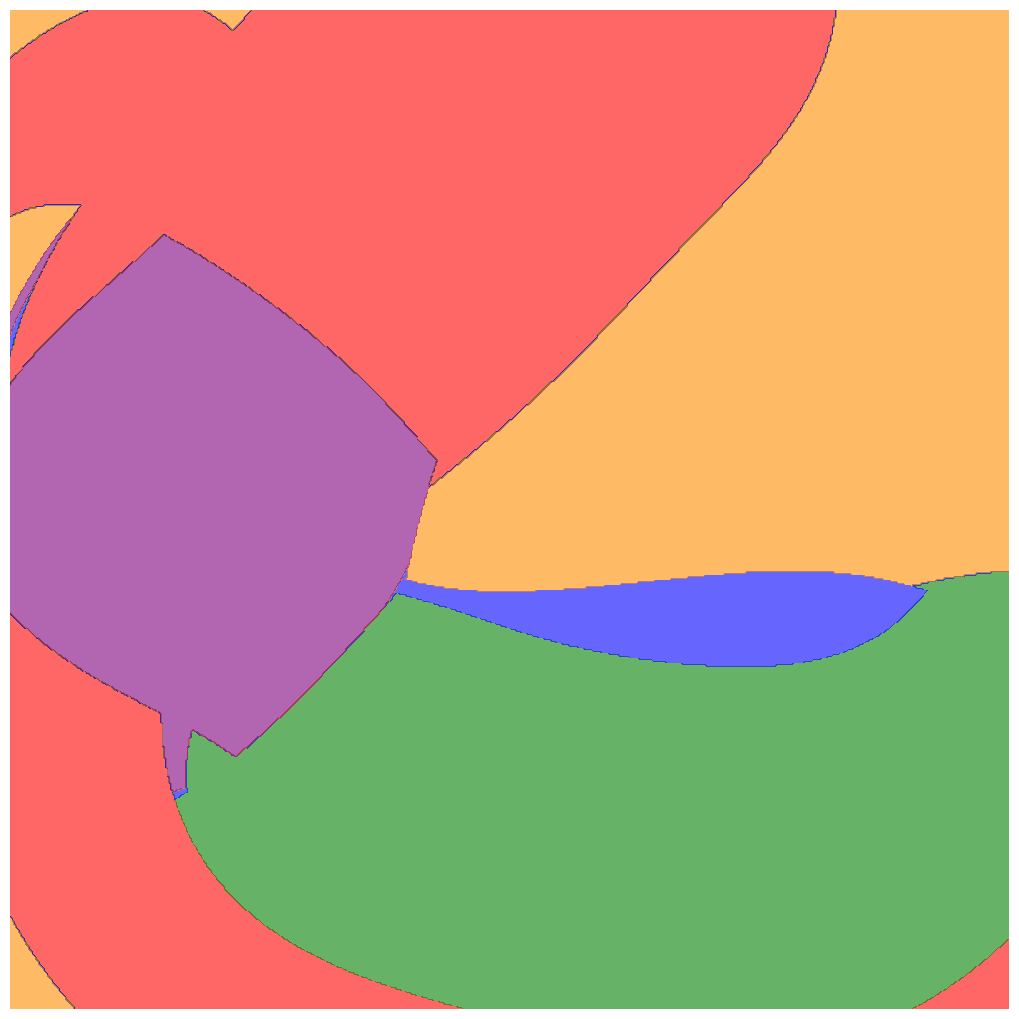

[3 3 3 ... 3 3 3]


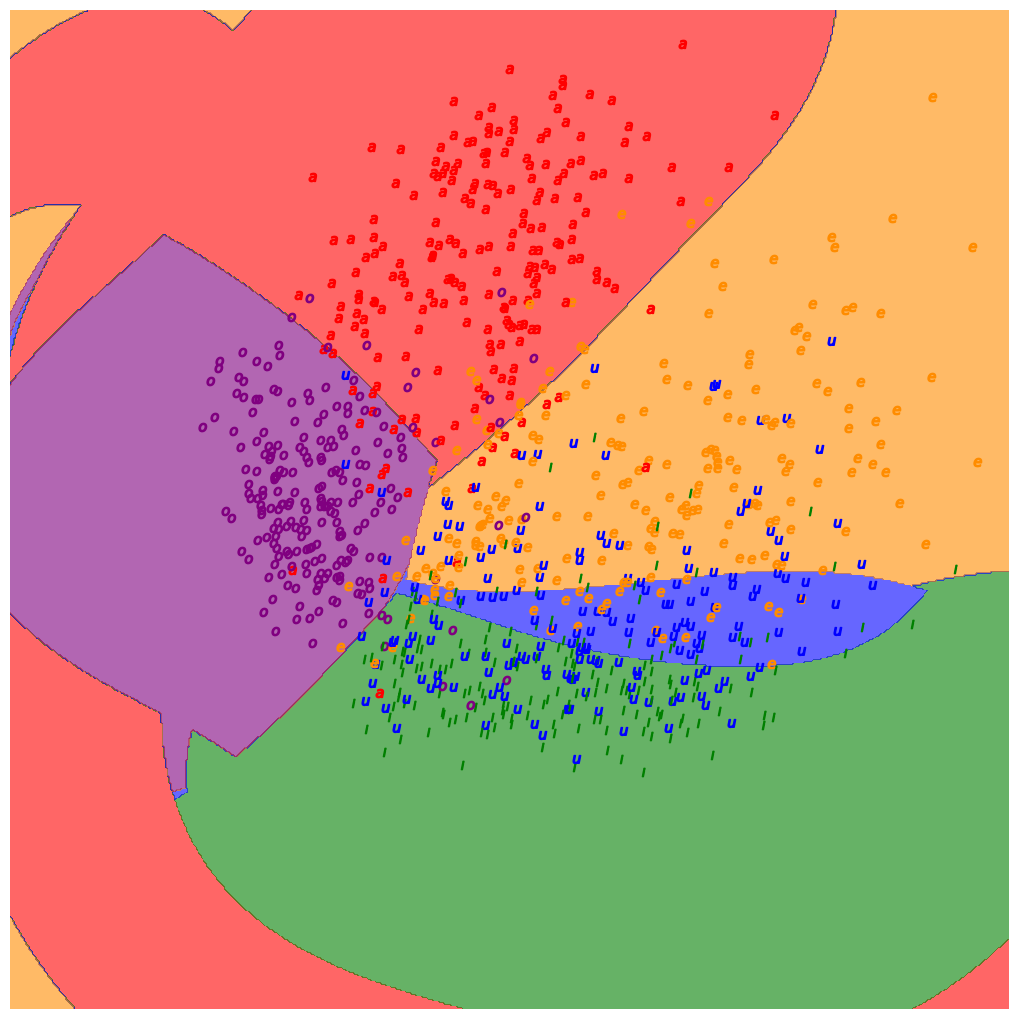

In [34]:
simulate(clf=algorithm,xs=data[0],ys=label[0])

In [35]:
model_save_path = "model_2dim.pth"
torch.save(model.state_dict(),model_save_path)

In [36]:
np.savetxt('z_points.csv', data[0], delimiter=',')
np.savetxt('z_labels.csv',label[0], delimiter=',')

In [37]:
share_data_params = []
share_data_params.append(sr)
share_data_params.append(n_fft)
share_data_params.append(hop_length)
share_data_params.append(n_mels)
share_data_params.append(dataset_mean)
share_data_params.append(dataset_std)
share_data_params.append(x_size)
share_data_params.append(y_size)
share_data_params.append(frame_len)
np.savetxt('share_data_params.csv', share_data_params, delimiter=',')

[]

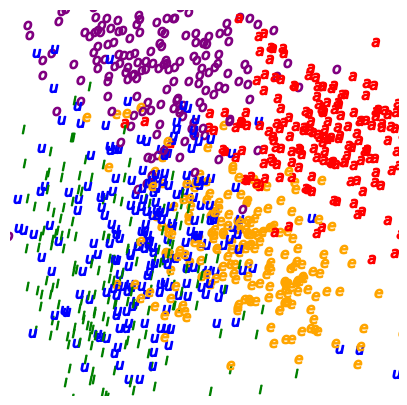

In [46]:
model.eval()
points=np.loadtxt('z_points.csv', delimiter=',')
label=np.loadtxt('z_labels.csv', delimiter=',')

label = label.astype(int)

labeltoword = ["a","i","u","e","o","a:","i:","u:","e:","o:"]
colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]

fig =plt.figure(figsize=(5,5))
ax=fig.add_subplot(1,1,1)


for p, l in zip(points, label):
    ax.scatter(p[0], p[1], marker="${}$".format(labeltoword[l]), c=colors[l])
ax.axis("off")
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.plot()

In [50]:
def get_default_microphone_info():
    try:
        p = pyaudio.PyAudio()
    except Exception as e:
        print(f"Error creating PyAudio instance: {e}")
        return None

    default_device_index = p.get_default_input_device_info()["index"]
    microphone_info = p.get_device_info_by_index(default_device_index)
    p.terminate()
    return microphone_info
microphone_info = get_default_microphone_info()

if microphone_info:
    print("Default Microphone Info:")
    print(f"Device Index: {microphone_info['index']}")
    print(f"Device Name: {microphone_info['name']}")
    print(f"Sample Rate: {microphone_info['defaultSampleRate']} Hz")
    print(f"Input Channels: {microphone_info['maxInputChannels']}")
    print(f"Output Channels: {microphone_info['maxOutputChannels']}")

Default Microphone Info:
Device Index: 1
Device Name: 繝槭う繧ｯ (USB Microphone)
Sample Rate: 44100.0 Hz
Input Channels: 1
Output Channels: 0
